# Example: Multidimensional Geometric Brownian Motion (MGBM)
Consider an asset portfolio $\mathcal{P}$ with a return covariance matrix $\Sigma$ and drift vector $\mu$. The multi-dimensional geometric Brownian motion model describing the share price $S_{i}(t)$ for asset $i\in\mathcal{P}$ is given by: 

$$
\begin{equation*}
\frac{dS_{i}\left(t\right)}{S_{i}(t)} = \mu_{i}\,{dt}+\sum_{j\in\mathcal{P}}a_{ij}\cdot{dW_{j}(t)}\qquad\text{for}\quad{i \in \mathcal{P}}
\end{equation*}
$$

where $a_{ij}\in\mathbf{A}$ and $\mathbf{A}\mathbf{A}^{\top} = \Sigma$, and $\mu_{i}$ denotes the drift parameter for asset $i$. The multi-dimensional GBM model has the analytical solution:

$$
\begin{equation*}
S_{i}(t_{k}) = S_{i}(t_{k-1})\cdot\exp\Biggl[\left(\mu_{i}-\frac{\sigma_{i}^{2}}{2}\right)\Delta{t} + \sqrt{\Delta{t}}\cdot\sum_{j\in\mathcal{P}}a_{ij}\cdot{Z_{j}(0,1)}\Biggr]\quad{i\in\mathcal{P}}
\end{equation*}
$$

where $S_{i}(t_{k-1})$ is the share price at time $t_{k-1}$ for asset $i\in\mathcal{P}$,  $\Delta{t} = t_{k} - t_{k-1}$ is the time difference (step-size) for each time step (fixed), and $Z_{j}(0,1)$ is a standard normal random variable. 

## Learning objective
This example aims to familiarize students with simulating the multi-dimensional geometric Brownian motion (MGBM) using a factorized version of the covariance matrix. This approach was reproduced from Chapter 3 of Glasserman (section 3.2.3):

* [Amazon: Monte Carlo Methods in Financial Engineering, Glasserman, Springer-Verlag, 2003, ISBN 10: 0387004513](https://www.amazon.com/Financial-Engineering-Stochastic-Modelling-Probability/dp/0387004513)

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`


In [2]:
include(joinpath(_PATH_TO_SRC, "CHEME-5660-L15a-MAGBM-CodeLibrary.jl"));

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `11-17-2023`, along with data for a few exchange traded funds and volatility products during that time. 

In [3]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-11-17-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [4]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

1480

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [5]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [6]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers);

### Compute the covariance and expected yield for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [7]:
all_firms_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = 0.0);

In [8]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

### Build single index model approximation of the covariance

In [9]:
sims = load(joinpath(_PATH_TO_DATA, "SIMs-PortfolioDriftExample-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["sims"]

Dict{String, MySingleIndexModel} with 459 entries:
  "NI"   => MySingleIndexModel(-0.0457744, 0.66336, 0.05, Normal{Float64}(μ=-1.…
  "EMR"  => MySingleIndexModel(-0.0140694, 1.25195, 0.05, Normal{Float64}(μ=-2.…
  "CTAS" => MySingleIndexModel(0.137176, 1.20845, 0.05, Normal{Float64}(μ=9.786…
  "HSIC" => MySingleIndexModel(-0.0465561, 0.93735, 0.05, Normal{Float64}(μ=1.2…
  "KIM"  => MySingleIndexModel(-0.0426714, 1.28931, 0.05, Normal{Float64}(μ=-3.…
  "PLD"  => MySingleIndexModel(0.0444956, 1.00113, 0.05, Normal{Float64}(μ=6.64…
  "IEX"  => MySingleIndexModel(0.0405578, 0.98168, 0.05, Normal{Float64}(μ=3.02…
  "BAC"  => MySingleIndexModel(-0.0543229, 1.31835, 0.05, Normal{Float64}(μ=-1.…
  "CBOE" => MySingleIndexModel(-0.0581238, 0.624313, 0.05, Normal{Float64}(μ=1.…
  "EXR"  => MySingleIndexModel(0.0440579, 0.694857, 0.05, Normal{Float64}(μ=8.0…
  "NCLH" => MySingleIndexModel(-0.397087, 2.34477, 0.05, Normal{Float64}(μ=-2.1…
  "CVS"  => MySingleIndexModel(-0.01761, 0.797209, 0.05, N

In [10]:
index_SPY = findfirst(x->x=="SPY", all_tickers);
R_SPY = μ[index_SPY];

Next let's build the `single index model` version of the covariance array. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifying) gives:

$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$

where $\sigma_{m}^2$ denotes the variance of the excess return of the market,  and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model.

In [11]:
σₘ = std(all_firms_return_matrix[:, index_SPY])

2.5414369559913688

We populate the single index covariance array using nested `for` loops:

In [12]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252);

## Task 1: Load Efficient Frontier and Select a Portfolio

In [13]:
efficient_frontier = load(joinpath(_PATH_TO_DATA,
        "EfficientFrontier-PortfolioDriftExample-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["dataset"]

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.84921e-7, 0.506115]",0.05
2,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.85803e-7, 0.506115]",0.05
3,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59537e-8, 4.87577e-7, 0.506115]",0.05
4,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80374e-8, 9.59542e-8, 5.32657e-7, 0.506115]",0.05
5,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80382e-8, 9.59546e-8, 5.69075e-7, 0.506115]",0.05
6,0.0388449,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80362e-8, 9.59585e-8, 1.40028e-6, 0.506114]",0.05
7,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80366e-8, 9.59546e-8, 5.08398e-7, 0.506115]",0.05
8,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80371e-8, 9.59552e-8, 5.25002e-7, 0.506115]",0.05
9,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80333e-8, 9.60306e-8, 1.00265e-6, 0.506114]",0.05


## Task 2: Select a portfolio from the efficient frontier

In [14]:
portfolio_index = 30;
my_list_of_tickers = efficient_frontier[portfolio_index,:tickers];
w = efficient_frontier[portfolio_index,:w] .|> x-> round(x,digits=6) .|> abs;
expected_excess_return = efficient_frontier[portfolio_index,:expected_excess_return] |> x-> round(x,digits=3)
println("The expected excess return for portfolio index $(portfolio_index) equals $(expected_excess_return)")

The expected excess return for portfolio index 30 equals 0.132


In [15]:
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute for you the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the $\hat{\mu}$ vector for the `data` and `single index model` versions of the problem:

In [16]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

In [17]:
μ̂

6-element Vector{Float64}:
 -0.03441697511214336
  0.10106475730994074
  0.3971687103237069
  0.09386832570022689
 -0.006095400496722701
  0.08726475731522582

and then we'll compute the firm-specific covariance $\hat{\Sigma}$ matrix for the `data` version of the problem:

In [18]:
# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 3: Simulate the asset price values using a Multivariate GBM model
Glasserman factors the covariance matrix $\Sigma = \mathbf{A}\mathbf{A}^{\top}$ using a [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition). This factorization is implemented in the [LinearAlgebra.jl](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/):

In [19]:
factors = cholesky(Σ̂);
A = factors.L |> x-> Matrix(x)
Â = diagm(0 => diag(A))

6×6 Matrix{Float64}:
 0.228754  0.0       0.0       0.0       0.0       0.0
 0.0       0.199681  0.0       0.0       0.0       0.0
 0.0       0.0       0.437927  0.0       0.0       0.0
 0.0       0.0       0.0       0.364422  0.0       0.0
 0.0       0.0       0.0       0.0       0.265593  0.0
 0.0       0.0       0.0       0.0       0.0       0.0911245

#### Check: Is Cholesky legit?

In [20]:
@assert isapprox(Σ̂, A*transpose(A),rtol = 1e-1)

### Set the initial conditions and the time range

Next, get the share price (which we approximate as the volume weighted average price) for each asset in the portfolio for the `startdate`. We'll store these values in the `Sₒ::Array{Float64,1}` variable:

In [21]:
startdate = Date(2023,01,03);
Δt = (1/252);
number_of_days = 222;
T = number_of_days*Δt;
number_of_steps = number_of_days + 1
number_of_trials = 100;
number_of_states = length(my_list_of_tickers);

In [22]:
Sₒ = Array{Float64,1}()
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:volume_weighted_average_price]
    push!(Sₒ,startprice)
end

In [23]:
time_array = range(0, stop = T, length = number_of_steps) |> collect;

### Simulation loop

In [24]:
simulation_dictionary = Dict{Int64,Array{Float64,2}}();
Z = Normal(0,1);
for trial_index ∈ 1:number_of_trials
    simulation_array = Array{Float64,2}(undef, number_of_steps, number_of_states + 1);
    
    # add initial condition to the array -
    simulation_array[1,1] = 0.0;
    for i ∈ 1:number_of_states
        simulation_array[1,i+1] = Sₒ[i];
    end
    
    # forward simulation -
    for i ∈ 2:number_of_steps
        t = time_array[i];
        simulation_array[i,1] = t;

        for j ∈ 1:number_of_states
            
            # compute the noise term for this state -
            noise_term = 0.0;
            for k ∈ 1:number_of_states
                noise_term += A[j,k]*rand(Z)
            end
            
            simulation_array[i,j+1] = simulation_array[i-1,j+1]*exp((μ̂[j] - Σ̂[j,j]/2)*Δt + (sqrt(Δt))*noise_term);
        end
    end
    simulation_dictionary[trial_index] = simulation_array;
end

## Task 4: Compute the port

First, let's specify how much we wish to invest in risky assets store this value in the `total_budget` variable:

In [25]:
total_budget = 1000.0;

Now that we have the `total_budget`, and the share price array `Sₒ`, we compute the number of shares of each asset that corresponds to the optimal allocation (the point in the efficient frontier) and store these values in the `Nₒ::Array{Float64,1}` variable (in this case, we allow for fractional shares):

In [26]:
Nₒ = Array{Float64,1}()
for i ∈ eachindex(w)
    
    wᵢ = w[i]
    nᵢ = (wᵢ*total_budget)/Sₒ[i];
    push!(Nₒ,nᵢ)
end
Nₒ;

#### Visualize
Let's visualize the relative wealth of the portfolio $W_{t}/W_{o}$ for our selected optimal portfolio versus an alternative portfolio consisting of `SPY` over the same time frame:

In [27]:
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);

In [28]:
p = plot();
simulated_wealth_array = Array{Float64,2}(undef, number_of_days, number_of_trials);
for i ∈ 1:number_of_trials
    
    simulation_array = simulation_dictionary[i]
    
    portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(w)+1)
    for j ∈ eachindex(my_list_of_tickers)
    
        ticker = my_list_of_tickers[j];
        price_data = simulation_array[:,j+1];
        nⱼ = Nₒ[j]
    
        for k ∈ 1:number_of_days
            portfolio_performance_array[k,j] = nⱼ*price_data[k];
        end
    end

    # total -
    for j ∈ 1:number_of_days
        portfolio_performance_array[j,end] = sum(portfolio_performance_array[j,1:end-1])
    end
    
    # wealth -
    for j ∈ 1:number_of_days
        simulated_wealth_array[j,i] = portfolio_performance_array[j,end];
    end
end

# actual -
actual_portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(w)+1)
for i ∈ eachindex(my_list_of_tickers)
    
    ticker = my_list_of_tickers[i];
    price_df = dataset[ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    nᵢ = Nₒ[i]
    
    for j ∈ 1:number_of_days
        actual_portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:volume_weighted_average_price];
    end
end

# total -
for i ∈ 1:number_of_days
    actual_portfolio_performance_array[i,end] = sum(actual_portfolio_performance_array[i,1:end-1])
end

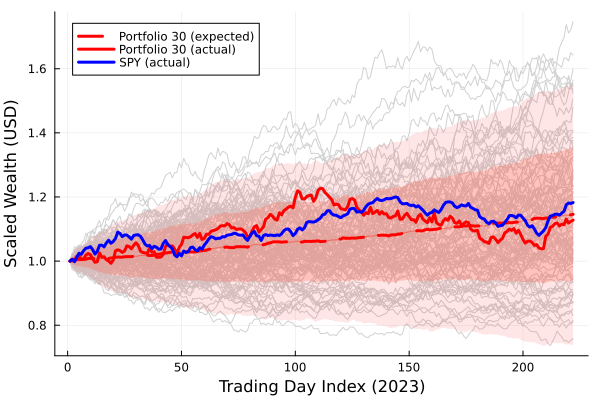

In [29]:
p = plot();

# plot the trajectories -
for i ∈ 1:number_of_trials
    plot!((1/total_budget)*simulated_wealth_array[:,i],c=:gray82,lw=1, label="")
end

# compute the expected wealth array, and bounds 0
expected_wealth_array = mean(simulated_wealth_array,dims=2)
L68 = (1/total_budget)*(expected_wealth_array .- std(simulated_wealth_array,dims=2))
U68 = (1/total_budget)*(expected_wealth_array .+ std(simulated_wealth_array,dims=2))
plot!((1/total_budget)*expected_wealth_array,fillrange=L68, c=:tomato, alpha=0.25,label="")
plot!((1/total_budget)*expected_wealth_array,fillrange=U68, c=:tomato, alpha=0.25, label="")

L95 = (1/total_budget)*(expected_wealth_array .- 1.96*std(simulated_wealth_array,dims=2))
U95 = (1/total_budget)*(expected_wealth_array .+ 1.96*std(simulated_wealth_array,dims=2))
plot!((1/total_budget)*expected_wealth_array,fillrange=L95, c=:red, alpha=0.1,label="")
plot!((1/total_budget)*expected_wealth_array,fillrange=U95, c=:red, alpha=0.1, label="")

plot!((1/expected_wealth_array[1]).*expected_wealth_array, ls=:dash, c=:red, lw=3, label="Portfolio $(portfolio_index) (expected)")

plot!((1/actual_portfolio_performance_array[1,end]).*actual_portfolio_performance_array[:,end], lw=3, 
    c=:red, label="Portfolio $(portfolio_index) (actual)")
plot!((1/SPY_df[1,:volume_weighted_average_price]).*SPY_df[1:number_of_days,:volume_weighted_average_price], lw=3, 
        c=:blue, label="SPY (actual)")
xlabel!("Trading Day Index (2023)", fontsize=18)
ylabel!("Scaled Wealth (USD)", fontsize=18)

## Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.